# Forward Solve

We solve the forward problem of simulating the surface temperature $T(x,y)$ within a unit square domain $[0,1]\times[0,1]$, with a spatially-varying thermal conductivity $h(x,y)$ and a constant heat source $q(x,y)=1$.

The system is described by the steady-state Poisson heat equation in two dimensions (2D) and subjected to the following mixed boundary conditions:
 - $T=300K$ at the bottom (Dirichlet).
 - Insulated walls, i.e. $\frac{\partial T}{\partial \hat{n}}$ ($\hat{n}$ being the surface unit vector), on the other three sides (Neumann).

In [1]:
from forward_solver import SteadyHeatForwardSolver2D

## Define domain


In [2]:
nmesh=128
mesh_type='quadrilateral'

## Define thermal conductivity

In [3]:
# spatially constant thermal conductivity
#def h_func(x):
    #return 1.0

# spatially-varying thermal conductivity
def h_func(x):
    return 1.0 + 6.0*x[0]**2 + x[0]/(1.0 + 2.0*x[1]**2)

## Define heat source

In [4]:
q=1.0 # constant heat source

## Define boundary condition

In [5]:
T_bottom=300. # in Kelvin, Dirichlet boundary condition on the bottom

## Initialize solver

Not all solvers are equal. Test different solvers and their settings. PETSc KSP Documentation: https://petsc.org/main/manual/ksp/

In [6]:
# Direct method, O(NlogN) memory scaling
## Any matrix decomposition
## Slow
# petsc_options={
#     "ksp_type": "preonly",
#     "pc_type": "lu", 
#     "pc_factor_mat_solver_type": "mumps",
# }
## SPD matrix decompositon, SPD ensured by h(x,y)>0
## Fast
# petsc_options = {
#     "ksp_type": "preonly",
#     "pc_type": "cholesky",
#     "pc_factor_mat_solver_type": "cholmod",
#     "mat_cholmod_factor": "simplicial"
# }
# [DEFAULT] Iterative method - algebraic multigrid (BoomerAMG), O(N) memory scaling
## Fast
petsc_options = {
     'ksp_type': 'cg',
     'pc_type': 'hypre',
     'ksp_rtol': 1e-12,
}

In [7]:
forward_solver=SteadyHeatForwardSolver2D(nmesh=nmesh, mesh_type=mesh_type, \
                                          h=h_func, q=q,\
                                          DBC_value=T_bottom,
                                          petsc_opts=petsc_options)

## Solve

In [8]:
%timeit T = forward_solver.solve()

25.5 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Visualize output $T(x,y)$

Plotting absolute temperature distribution T(x,y).


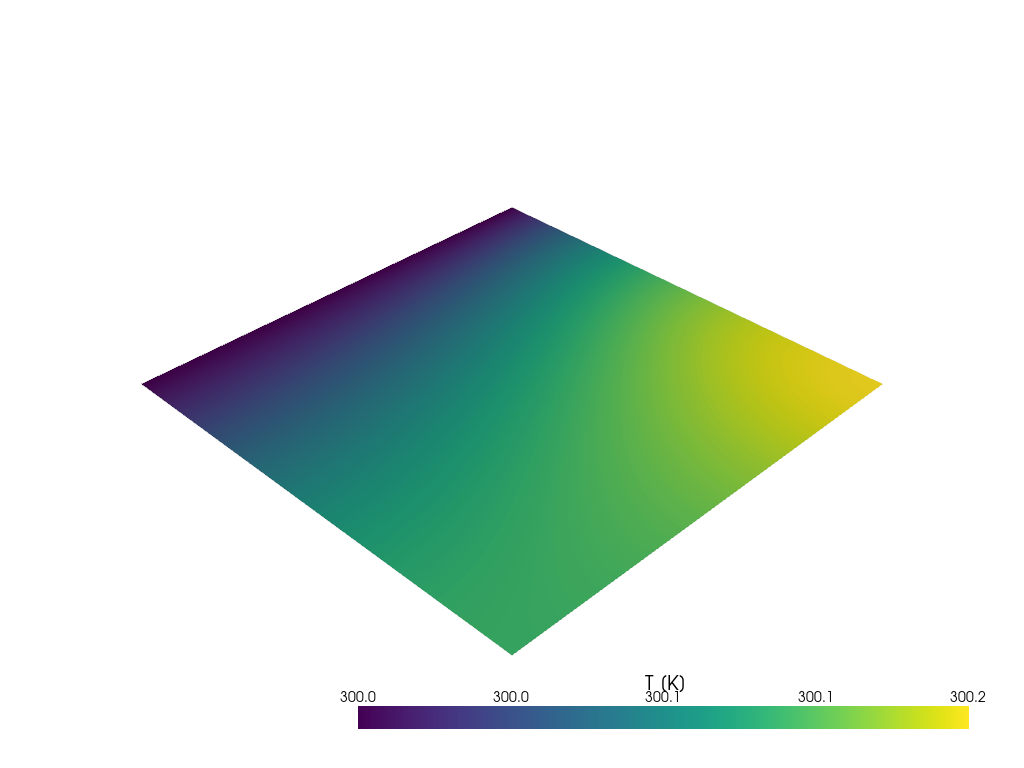

In [9]:
pl = forward_solver.plot_output_temperature(zero_point=0.)
pl.camera_position = 'yx'

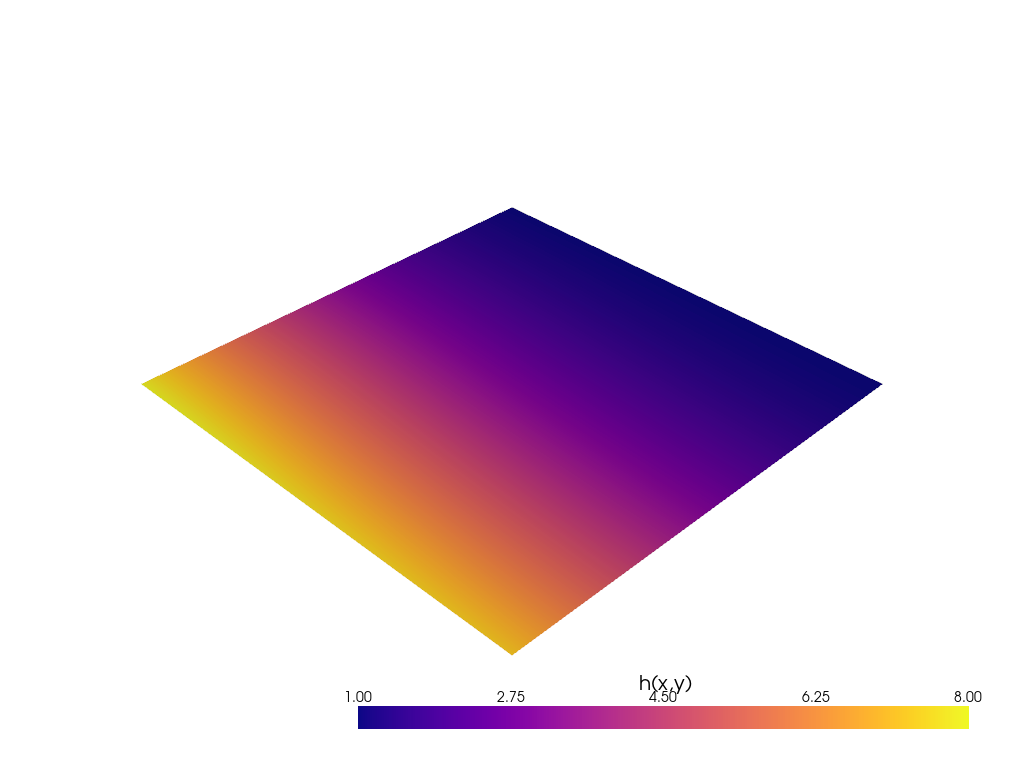

UnstructuredGrid (0x1072b3ca0)
  N Cells:    16384
  N Points:   16641
  X Bounds:   0.000e+00, 1.000e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

In [10]:
forward_solver.h.plot_input_thermal_conductivity(user_scalar_bar={"fmt": "%.2f"})

In [11]:
sigma = 1e-3 ## noise std.
T_obs = forward_solver.add_noise(0.,sigma)

Plotting absolute temperature distribution T(x,y).


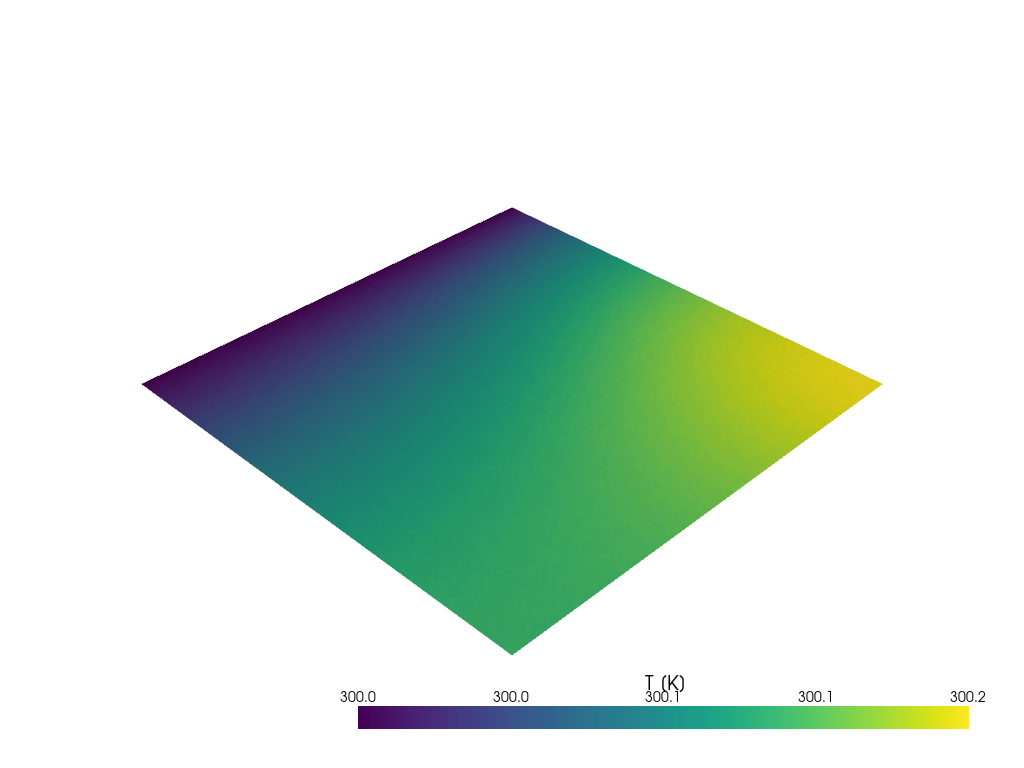

In [12]:
pl = forward_solver.plot_output_temperature(zero_point=0.,noiseless=False)
pl.camera_position = 'yx'

## Save output to disk

In [13]:
import os
test_dir='../test_data/'
test_outfile_name='blackbox_output'
test_outfile_format='.xdmf'
forward_solver.export_xdmf(os.path.join(test_dir,test_outfile_name+test_outfile_format))

## Load saved output from disk

In [14]:
import h5py as h5

def list_h5(name, obj):
    """
    HDF5 IO helper
    """
    if isinstance(obj, h5.Dataset):
        print(f"{name}    Dataset, shape={obj.shape}, dtype={obj.dtype}")
    else:
        print(f"{name}    Group")

test_outfile_format='.h5'
with h5.File(os.path.join(test_dir,test_outfile_name+test_outfile_format), 'r') as f:
    f.visititems(list_h5)

Function    Group
Function/HeatSource    Group
Function/HeatSource/0    Dataset, shape=(16641, 1), dtype=float64
Function/ObservedTemperature    Group
Function/ObservedTemperature/0    Dataset, shape=(16641, 1), dtype=float64
Function/Temperature    Group
Function/Temperature/0    Dataset, shape=(16641, 1), dtype=float64
Function/ThermalConductivity    Group
Function/ThermalConductivity/0    Dataset, shape=(16641, 1), dtype=float64
Mesh    Group
Mesh/mesh    Group
Mesh/mesh/geometry    Dataset, shape=(16641, 2), dtype=float64
Mesh/mesh/topology    Dataset, shape=(16384, 4), dtype=int64
